In [2]:
import os
import sys

cwd = os.getcwd()
pwd = cwd[:cwd.rfind('/')]
sys.path.append(pwd)

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from dataloader import DatasetTrainClean, DatasetClean

/home/liao0090/miniconda3/envs/cvtorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dataset
data_path = '../data/'
trn_dataset = DatasetTrainClean(data_path)
val_dataset = DatasetClean(data_path)
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=8, shuffle=False, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1)

labs = ['bckgrnd', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'cnstn', 'plant', 'road', 'sky']
cmap = np.array([
        #  R,   G,   B
        (  0,   0,   0),  #  Background
        (192, 128, 128),  #  Person
        (  0, 128,   0),  #  Bike
        (128, 128, 128),  #  Car
        (128,   0,   0),  #  Droneå
        (  0,   0, 128),  #  Boat
        (192,   0, 128),  #  Animal
        (192,   0,   0),  #  Obstacle
        (192, 128,   0),  #  Construction
        (  0,  64,   0),  #  Plant
        (128, 128,   0),  #  Road
        (  0, 128, 128)   #  Sky
    ])

In [18]:
frqn_ins = np.zeros((12), dtype=int)        # Frequency by instances
frqn_pxl = np.zeros((12), dtype=np.float64) # Frequency by pixels
frqn_pos = np.zeros((720, 1280, 12))        # Frequency in position

for batch_i, (x, y) in tqdm(enumerate(trn_dataloader)):
    y = torch.Tensor(y).long()
    frq = F.one_hot(y, num_classes=12)
    frq = torch.sum(frq, axis=0)
    for c in range(12):
        s = torch.sum(frq[:,:,c]).numpy()
        if s > 0:
            frqn_ins[c] += 1
            frqn_pxl[c] += s
    frqn_pos += frq.numpy()

656it [02:05,  5.22it/s]


In [15]:
frqv_ins = np.zeros((12), dtype=int)
frqv_pxl = np.zeros((12), dtype=np.float64)
frqv_pos = np.zeros((720, 1280, 12)) 

for batch_i, (x, y) in tqdm(enumerate(val_dataloader)):
    y = torch.Tensor(y).long()
    frq = F.one_hot(y, num_classes=12)
    frq = torch.sum(frq, axis=0)
    for c in range(12):
        s = torch.sum(frq[:,:,c]).numpy()
        if s > 0:
            frqv_ins[c] += 1
            frqv_pxl[c] += s
    frqv_pos += frq.numpy()

162it [00:31,  5.20it/s]


In [21]:
rtn_ins = frqn_ins / len(trn_dataset)       # Ratio by instances on train
rtn_pxl = frqn_pxl / np.sum(frqn_pxl)       # Ratio by pixels on train
rtv_ins = frqv_ins / len(val_dataset)       # Ratio by instances on validation
rtv_pxl = frqv_pxl / np.sum(frqv_pxl)       # Ratio by pixels on validation
np.sum(rtn_pxl)

1.0

## Bar plot

[(0.0, 0.3), Text(0, 0.5, 'Ratio by Image')]

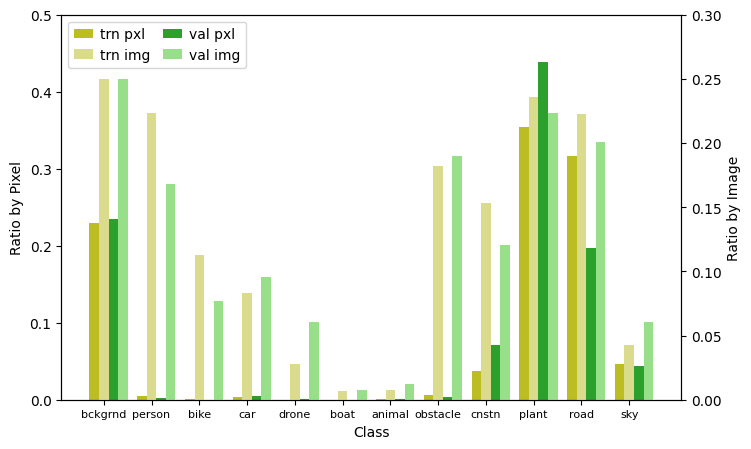

In [37]:
fig, ax_pxl = plt.subplots(figsize=(8, 5))
cm = plt.cm.tab20(np.arange(0, 20))
ax_ins = ax_pxl.twinx()

width = 0.2
x = np.arange(len(labs))
p1 = ax_pxl.bar(x-width,     rtn_pxl, width=width, color=cm[16], align='center', label='trn pxl')
p2 = ax_ins.bar(x,           rtn_ins, width=width, color=cm[17], align='center', label='trn img')
p3 = ax_pxl.bar(x+(width*1), rtv_pxl, width=width, color=cm[4],  align='center', label='val pxl')
p4 = ax_ins.bar(x+(width*2), rtv_ins, width=width, color=cm[5],  align='center', label='val img')

lst = [p1,p2,p3,p4]
ax_pxl.legend(handles=lst, ncol=2, loc=0,
            columnspacing=0.9, handlelength=1.4, handletextpad=0.5,)

ax_pxl.set_xticks(x, labs, fontsize=8)
ax_pxl.set(ylim=[0, 0.5], ylabel='Ratio by Pixel', xlabel='Class')
ax_ins.set(ylim=[0, 0.3], ylabel='Ratio by Image')

[(0.0, 0.3), Text(0, 0.5, 'Ratio by Image')]

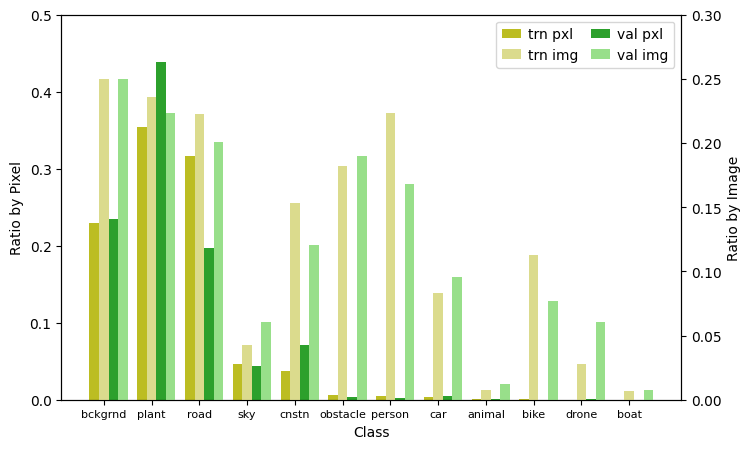

In [38]:
fig, ax_pxl = plt.subplots(figsize=(8, 5))
cm = plt.cm.tab20(np.arange(0, 20))
ax_ins = ax_pxl.twinx()

width = 0.2
x = np.array([0., 6, 9, 7, 10, 11, 8, 5, 4, 1, 2, 3])
p1 = ax_pxl.bar(x-width,     rtn_pxl, width=width, color=cm[16], align='center', label='trn pxl')
p2 = ax_ins.bar(x,           rtn_ins, width=width, color=cm[17], align='center', label='trn img')
p3 = ax_pxl.bar(x+(width*1), rtv_pxl, width=width, color=cm[4],  align='center', label='val pxl')
p4 = ax_ins.bar(x+(width*2), rtv_ins, width=width, color=cm[5],  align='center', label='val img')

lst = [p1,p2,p3,p4]
ax_pxl.legend(handles=lst, ncol=2, loc=0,
            columnspacing=0.9, handlelength=1.4, handletextpad=0.5,)

ax_pxl.set_xticks(x, labs, fontsize=8)
ax_pxl.set(ylim=[0, 0.5], ylabel='Ratio by Pixel', xlabel='Class')
ax_ins.set(ylim=[0, 0.3], ylabel='Ratio by Image')

## Avg Image

In [47]:
frq_pos = frqn_pos + frqv_pos
rtn_pos = frq_pos / (len(trn_dataset) + len(val_dataset))
img_avg = np.zeros((720, 1280, 3), dtype=np.float64) 

for c in range(12):
    img_avg += rtn_pos[:,:,c][:, :, None] * cmap[c]

(-0.5, 1279.5, 719.5, -0.5)

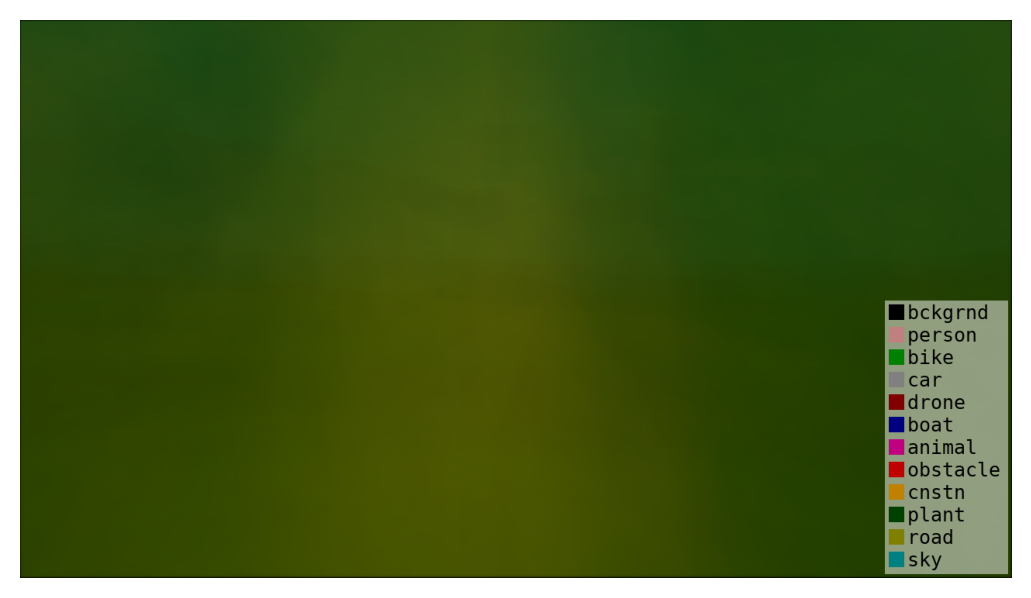

In [58]:
import imgviz

img = img_avg.astype('uint8')
lab_avg = np.zeros(img.shape[:2], dtype=int)
lab_avg[0, :12] = np.arange(12)
labelviz = imgviz.label2rgb(
            label=lab_avg, image=img, alpha=0.0,
            label_names=labs, colormap=cmap, font_size=25, loc="rb"
        )

plt.figure(dpi=200)
plt.imshow(labelviz)
plt.axis("off")